### Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


### get classes

### load and normalize dog dataset

In [2]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import math

#transformer for normalization of images
# transforms.Compose -> pipeline that in this case firstly converts image to tensor and then normalizes it
# - first (0.5, 0.5, 0.5) are the mean for each channel(red, green, blue) and 
# - second is the standard deviation for each channel
# - resize the pictures from 275x183 to 28x28
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((28,28), antialias=False),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#batch, to have a certain amount of example pictures
batch_size = 16



#trainset
train_dir = '/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/train'
#testset
test_dir = '/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/test'

#load trainset
train_set = ImageFolder(train_dir,transform = transform)

#load testset
test_set = ImageFolder(test_dir,transform = transform)



#calculate the size of the training and validation set 
train_size = int(0.8 * len(train_set))  # 80% for training
val_size = len(train_set) - train_size

#Split train_set into training and validation set
train_data, val_data = random_split(train_set,[train_size, val_size], generator=torch.Generator().manual_seed(42))

#?????
trainloader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 0)
valloader = DataLoader(val_data, batch_size, shuffle = True, num_workers = 0)


testloader = DataLoader(test_set, batch_size, shuffle = False, num_workers = 0)


### Print random image

Label : African_hunting_dog


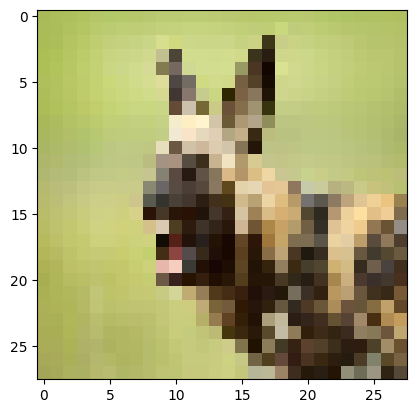

In [3]:
import matplotlib.pyplot as plt
import numpy as np

#Get classes (folder names) of the training set
classes = train_set.classes

#functions to show an image out of the Training set
#print("Follwing classes are there : \n",train_set.classes)
def display_img(img,label):
    print(f"Label : {train_set.classes[label]}")
    img = img / 2 + 0.5 # unnormalize picture
    plt.imshow(img.permute(1,2,0))

#display the first image [0] in the dataset
display_img(*train_set[0])    # * to unpack the tuple: (img, label)

0 torch.Size([16, 3, 28, 28])
1 torch.Size([16, 3, 28, 28])
2 torch.Size([16, 3, 28, 28])
3 torch.Size([16, 3, 28, 28])
4 torch.Size([16, 3, 28, 28])
5 torch.Size([16, 3, 28, 28])
6 torch.Size([16, 3, 28, 28])
7 torch.Size([16, 3, 28, 28])
8 torch.Size([16, 3, 28, 28])
9 torch.Size([16, 3, 28, 28])
10 torch.Size([16, 3, 28, 28])
11 torch.Size([16, 3, 28, 28])
12 torch.Size([16, 3, 28, 28])
13 torch.Size([16, 3, 28, 28])
14 torch.Size([16, 3, 28, 28])
15 torch.Size([16, 3, 28, 28])
16 torch.Size([16, 3, 28, 28])
17 torch.Size([16, 3, 28, 28])
18 torch.Size([16, 3, 28, 28])
19 torch.Size([16, 3, 28, 28])
20 torch.Size([16, 3, 28, 28])
21 torch.Size([16, 3, 28, 28])
22 torch.Size([16, 3, 28, 28])
23 torch.Size([16, 3, 28, 28])
24 torch.Size([16, 3, 28, 28])
25 torch.Size([16, 3, 28, 28])
26 torch.Size([16, 3, 28, 28])
27 torch.Size([16, 3, 28, 28])
28 torch.Size([16, 3, 28, 28])
29 torch.Size([16, 3, 28, 28])
30 torch.Size([16, 3, 28, 28])
31 torch.Size([16, 3, 28, 28])
32 torch.Size([16,

KeyboardInterrupt: 

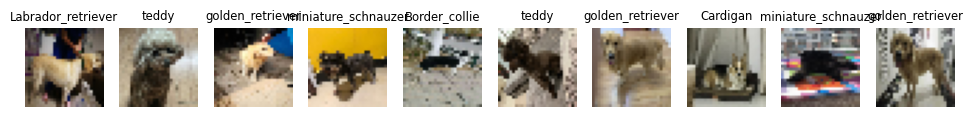

In [4]:
from matplotlib import pyplot as plt
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = train_data[i]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, train_set.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y}', fontsize='small')

# Hat das val_data images aus allen Klassen?
# -> ja
'''
arrY = []
for i in range(val_size):
    X,y = val_data[i]
    arrY.append(y)
    
uArr = np.unique(arrY)
uArr
'''
for i, batch in enumerate(valloader):
    X, y = batch
    print(i, X.size())


In [5]:
from tqdm import tqdm
import sys
import torch, torch.nn as nn, torch.nn.functional as F

class MyCNNModel(nn.Module):
    def __init__(self, *layers, lr=0.01, classes=None):
        super().__init__() # <- Very important! __init__ from parent class torch.nn 
        self.lr = lr    # learning rate
        self.classes = classes  # classes 
        ## Build model
        self.layers = nn.Sequential(*layers) # Create a sequential model, see below
    
    # Forward pass through the given layers, needed by torch.nn, which is used by train_step
    def forward(self, X):
        return self.layers(X)
    
    # Used after training to predict with the generated model
    def predict(self, X):
        with torch.no_grad():
            y_hat = self(X).argmax(1)
        if self.classes is not None:
            y_hat = [self.classes[i] for i in y_hat]
        return y_hat
    
    # Actual forward pass
    def train_step(self, X, y):
        y_hat = self(X)   # y_hat = prediction, self(X) calls the forward() function above
        # y_hat needs to be the shape (batch_size, classes)
        # y needs to be the shape of batch_size and contain the class of each sample
        # calculates the "cross_entropy"-loss, is y_hat == y
        y.shape
        return F.cross_entropy(y_hat, y) 
        
    def validation_step(self, X, y):
        # temporarily disable gradient, because you don't need it during validation
        with torch.no_grad():
            # calculate the loss, just without the gradient-calculation
            return self.train_step(X, y)
    
    def configure_optimizers(self):
        # self.parameters() = returns an iterator over all the learnable parameters of the model
        # SGD = optimization alg. for nn
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer
        
    def fit(self, train_loader, valid_loader, epochs=10):
        # Load Optimizer
        optimizer = self.configure_optimizers()
        
        # Amount of epochs, one epoch is when all batches are fed into the model to train at once
        for epoch in range(epochs):
            print(f'{epoch+1}/{epochs}:')
            # Training
            self.train() # Set model to training mode
            # tqm = loading bar, tepoch == array of all batches
            with tqdm(train_loader, unit="batch", desc='Train: ', colour='#1f77b4',\
                      file=sys.stdout, ncols=80) as tepoch:
                # for each batch in tepoch
                for X,y in tepoch:
                    optimizer.zero_grad(set_to_none=True) # Sets all gradients to Zero
                    loss = self.train_step(X, y) # Execute Forward pass
                    loss.backward() # Execute Backwval_dataard pass
                    optimizer.step() # Update weights
                    tepoch.set_postfix(loss=f'{loss.item():1.4f}') # Update progress bar
                    
            # Validation
            self.eval() # Set model to validation mode
            with tqdm(train_loader, unit="batch", desc='Valid: ', colour='#ff7f0e',\
                      file=sys.stdout, ncols=80) as tepoch:
                for X,y in tepoch:
                    loss_valid = self.validation_step(X, y) # Execute Forward pass without gradients
                    tepoch.set_postfix(loss=f'{loss_valid.item():1.4f}') # Update progress bar
            
        return self

In [6]:
model1 = MyCNNModel(
    # different functions from torch.nn to modify the model 
    nn.Conv2d(3, 6, (5,5), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, (5,5), padding='same'),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 10),
    classes=train_set.classes,
).fit(trainloader, valloader, epochs=10)

1/10:
Train:   0%|                                        | 0/1586 [00:00<?, ?batch/s]


IndexError: Target 16 is out of bounds.

In [ ]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = testset[i]
    y_hat = model1.predict(X.unsqueeze(0))[0]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, testset.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')

In [ ]:
model2 = MyCNNModel(
    nn.Conv2d(3, 8, (3,3), padding='same'),
    nn.ReLU(),
    nn.Conv2d(8, 8, (3,3), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, (3,3), padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 16, (3,3), padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 16, (3,3), padding='same'),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 10),
    classes=testset.classes,
).fit(trainloader, testloader, epochs=10)

In [ ]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = testset[i]
    y_hat = model2.predict(X.unsqueeze(0))[0]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, testset.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')